In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [5]:

df = pd.read_csv("SalesCars.csv")


print(df.head(5))

      Brand     Model Fuel_Type Transmission  Body_Type   Color  Price_INR  \
0    Toyota  Fortuner    Petrol       Manual  Hatchback   Black    3145093   
1      Audi        A3    Diesel    Automatic      Coupe  Silver    3578038   
2  Mercedes       GLA    Petrol    Automatic     Pickup     Red    7823377   
3      Tata   Harrier  Electric       Manual     Pickup   Green    1562274   
4    Toyota     Camry    Petrol    Automatic      Sedan   White    3457770   

   Engine_Size  Horsepower  Units_Sold  Top_Speed Customisable_Interiors  \
0          2.8         179       11886        218                     No   
1          2.7         358       17088        292                    Yes   
2          4.2         444        8696        245                    Yes   
3          2.1         194       19729        183                    Yes   
4          2.6         146        8034        197                     No   

   Mileage_kmpl  Profitability  
0          15.3              1  
1       

In [6]:
highest = df.loc[df["Units_Sold"].idxmax()]
lowest = df.loc[df["Units_Sold"].idxmin()]

print("max sold:", highest[["Brand", "Model", "Units_Sold"]])
print("\nmin sold:", lowest[["Brand", "Model", "Units_Sold"]])

highest = df.loc[df["Price_INR"].idxmax()]
lowest = df.loc[df["Price_INR"].idxmin()]

print("\nmax price:", highest[["Brand", "Model", "Price_INR"]])
print("\nmin price:", lowest[["Brand", "Model", "Price_INR"]])

max sold: Brand              Kia
Model         Carnival
Units_Sold       19968
Name: 162, dtype: object

min sold: Brand           Tata
Model         Safari
Units_Sold       506
Name: 136, dtype: object

max price: Brand        Mercedes
Model             GLA
Price_INR    11847489
Name: 50, dtype: object

min price: Brand          Tata
Model        Safari
Price_INR    625771
Name: 391, dtype: object


In [7]:
#new column for encoding sale 1 = good sale, 0 = not good
threshold = 9000

df["Profitability"] = (df["Units_Sold"] > threshold).astype(int)
print(df[["Brand", "Model", "Units_Sold", "Profitability"]].head(15))

       Brand     Model  Units_Sold  Profitability
0     Toyota  Fortuner       11886              1
1       Audi        A3       17088              1
2   Mercedes       GLA        8696              0
3       Tata   Harrier       19729              1
4     Toyota     Camry        8034              0
5      Honda    Accord        2991              0
6    Hyundai       i20       16851              1
7        Kia    Seltos       12166              1
8       Ford    Fiesta        1884              0
9       Tata   Harrier       17248              1
10      Audi        A4        1567              0
11   Hyundai     Creta         887              0
12       Kia  Sportage        8270              0
13      Audi        A4       12462              1
14       BMW  5 Series        8226              0


In [8]:
df.to_csv("SalesCars.csv", index=False)

In [43]:

#feature to ask
features = ["Body_Type", "Transmission", "Fuel_Type", "Color", "Price_INR", "Horsepower", "Top_Speed", "Customisable_Interiors", "Mileage_kmpl"]



X = df[features]
y = df["Profitability"]

#one-hot encode categorical, scale price
# Features
cat_cols = ["Body_Type", "Transmission", "Fuel_Type", "Color", "Customisable_Interiors"]
num_cols = ["Price_INR", "Horsepower", "Top_Speed", "Mileage_kmpl"]

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])
X_processed = preprocessor.fit_transform(X)

#split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Updated FNN
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    
    Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # ✅ Added new hidden layer
    BatchNormalization(),

    Dense(1, activation="sigmoid")
])

# Lower learning rate Adam
optimizer = Adam(learning_rate=0.005)

#Callbacks for optimization
early_stop = EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,     # reduce LR by half
    patience=5,     # wait for 5 epochs of no improvement
    min_lr=1e-4
)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train with callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=22,
    class_weight=class_weight,
    validation_split=0.2,
    callbacks=[reduce_lr],  
    verbose=1
)

#input for prediction
def predict_user_input(body_type, transmission, fuel_type, color, horsepower, top_speed, customisable_interiors, mileage_kmpl, price):
    user_df = pd.DataFrame([{
        "Body_Type": body_type,
        "Transmission": transmission,
        "Fuel_Type": fuel_type,
        "Color": color,
        "Horsepower": horsepower,
        "Top_Speed": top_speed,
        "Customisable_Interiors": customisable_interiors,
        "Mileage_kmpl": mileage_kmpl,
        "Price_INR": price,
    }])

    user_processed = preprocessor.transform(user_df)
    prob = model.predict(user_processed)[0][0]
    prediction = 1 if prob >= 0.5 else 0
    return prediction, prob



Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5094 - loss: 1.2260 - val_accuracy: 0.5375 - val_loss: 0.8792 - learning_rate: 0.0050
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5656 - loss: 1.0482 - val_accuracy: 0.5250 - val_loss: 0.8825 - learning_rate: 0.0050
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5844 - loss: 1.0026 - val_accuracy: 0.5625 - val_loss: 0.8790 - learning_rate: 0.0050
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.9425 - val_accuracy: 0.5625 - val_loss: 0.8803 - learning_rate: 0.0050
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 0.9202 - val_accuracy: 0.5625 - val_loss: 0.8782 - learning_rate: 0.0050
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6750 - loss: 0.9012 - val_accuracy: 0.5250 - val_loss: 0.8863 - learning_rate: 0.0050
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6906 - loss: 0.8810 - val_accuracy: 0.56

In [34]:
#user input section
print("\nSales Prediction Tool ")

body_type = input("Body Type (Sedan/SUV/Pickup/Coupe/Hatchback): ")
transmission = input("Transmission (Manual/Automatic): ")
fuel_type = input("Fuel Type: ")
color = input("Color (Red/Blue/Black/White/Silver/Grey/Green): ")
horsepower = int(input("Horsepower (e.g., 150 ): "))
top_speed = int(input("Top Speed (e.g., 180): "))
customisable_interiors = input("Customisable Interiors (Yes/No): ")
mileage_kmpl = int(input("Mileage (km/l) (e.g., 15): "))
price = int(input("Enter Price (INR): "))
prediction, prob = predict_user_input(body_type, transmission, fuel_type, color, horsepower, top_speed, customisable_interiors, mileage_kmpl, price)

print("\nPrediction:")
print(f"Probability of selling profitable units: {prob:.2f}")
print("\nThis Car model is likely to sell well." if prediction == 1 else "\nThis Car model has a chance of not selling well.")


Sales Prediction Tool 


ValueError: invalid literal for int() with base 10: ''

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


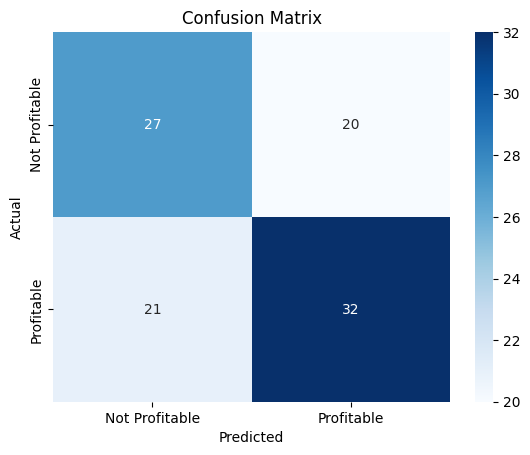

                precision    recall  f1-score   support

Not Profitable       0.56      0.57      0.57        47
    Profitable       0.62      0.60      0.61        53

      accuracy                           0.59       100
     macro avg       0.59      0.59      0.59       100
  weighted avg       0.59      0.59      0.59       100



In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Profitable", "Profitable"],
            yticklabels=["Not Profitable", "Profitable"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Not Profitable", "Profitable"]))